In [1]:
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import csv

## Download Data

### Define the boundaries, must be the same used when doing the PNSN query

In [2]:
def read_dataset():
    df = pd.read_csv('https://media.githubusercontent.com/media/Benz-Poobua/ESS-469-Project/main/bulk_event_magnitude_phase_nwf_FV.csv', parse_dates=['datetime', 'arrdatetime'], index_col=[0])
    df.index = df.arid
    # Explicitly (re)define the bounding box used for the PNSN catalog query
    latll, lonll = 42.0, -125.5
    latur, lonur = 49.0, -122.0
    t0, t1 = UTCDateTime(2015,1,1), UTCDateTime(2023,11,17)
    df= df[
        (df.lat >= latll)
        & (df.lat <= latur)
        & (df.lon >= lonll)
        & (df.lon <= lonur)
    ]
    feature_df = df.copy().iloc[:, -140:]
    data_arr = np.empty((0, 140), dtype=np.float16)
    target_arr = np.empty((0, 1), dtype=np.float16)
    # dataframe of the last 140 columns to numpy array
    for i in df.arid.unique():
        data_arr = np.append(data_arr, np.array([feature_df.loc[i]], dtype=np.float16), axis=0)
        target_arr = np.append(target_arr, np.array([[df.loc[i].magnitude]], dtype=np.float16), axis=0)
    return data_arr, target_arr

In [3]:
# Save the array to file so it is easier to load for future use
def save_array(filename, arr):
    # save the array to a file
    np.save(filename, arr)

In [4]:
# Defined function to import numpy array for future use
def import_array(filename):
    # import the array from the file
    arr = np.load(filename)
    return arr

In [5]:
# check if the file exists
if os.path.isfile('bulk_event_magnitude_phase_nwf_FV.npy') and os.path.isfile('bulk_event_magnitude_phase_nwf_FV_target.npy'):
    data_arr = import_array('bulk_event_magnitude_phase_nwf_FV.npy')
    target_arr = import_array('bulk_event_magnitude_phase_nwf_FV_target.npy')
else:
    data_arr, target_arr = read_dataset()
    save_array('bulk_event_magnitude_phase_nwf_FV.npy', data_arr)
    save_array('bulk_event_magnitude_phase_nwf_FV_target.npy', target_arr)

In [6]:
X = data_arr # feature vectors
y = target_arr # magnitude

In [7]:
print(X.shape)
print(y.shape)

(65821, 140)
(65821, 1)


## Data Splitting

### We decided to use an 80% split for training and 20% for testing

In [8]:
# Splitting the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Check shapes of arrays, the x must be (x,140) and y must (x,1) x should be equal for both training and testing sets

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(52656, 140)
(13165, 140)
(52656, 1)
(13165, 1)


## Data Distribution

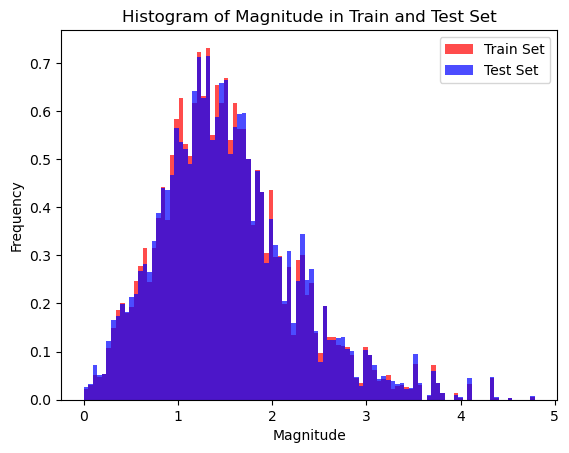

In [10]:
plt.hist(y_train, bins=100, density=True, alpha=0.7, color='red', label='Train Set')
plt.hist(y_test, bins=100, density=True, alpha=0.7, color='blue', label='Test Set')
#plt.hist(y, bins=100, density=True, alpha=0.3, color='yellow', label='Full Set')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Magnitude in Train and Test Set')
plt.show()

In [11]:
# Scalar Transform the Test and Train data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1057: RuntimeWarning: invalid value encountered in subtract
  temp = X - T
/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:1023: RuntimeWarning: invalid value encountered in subtract
  X -= self.mean_


## K-fold Cross Validation with XGBoost

In [12]:
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [13]:
# K-fold cross-validation setting
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=False)

In [14]:
# XGBoost model wit MAE loss function
# model = XGBRegressor(objective='reg:squarederror')
model_xgb = make_pipeline(StandardScaler(), xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                                                             learning_rate=0.05, max_depth=4, min_child_weight=1.7817,
                                                             n_estimators=6000,reg_alpha=0.4640, reg_lambda=0.8571, 
                                                             subsample=0.8, verbosity=0, nthread=-1))

### Model

In [15]:
# X_train contains the features (f000, f001, ..., f139) and y_train contains 'magnitude'
# Perform cross-validation with MAE as the loss function
mae_scores = cross_val_score(model_xgb, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=kfold)

# Take the absolute values of the mean absolute error scores
mae_scores = -mae_scores


/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/suphakornpoobua/

In [16]:
# Print the mean and standard deviation of MAE scores
print(f'Mean MAE: {mae_scores.mean()}')
print(f'Standard Deviation of MAE: {mae_scores.std()}')

Mean MAE: 0.28282909989356997
Standard Deviation of MAE: 0.002846798773827519


In [17]:
#fit the model to the entire training set
model_xgb.fit(X_train_scaled, y_train)

/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.4603, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.0468,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=1.7817, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=6000, n_jobs=None, nthread=-1,
                              num_parallel_tree=None, ...))])

In [18]:
from sklearn.metrics import mean_absolute_error
# Make predictions on the test set
y_pred=model_xgb.predict(X_test_scaled)
# Calculate Mean Absolute Error (MAE) on the test set
mae_test = mean_absolute_error(y_test, y_pred)
# Print the MAE on the test set
print(f'MAE on the Test Set: {mae_test}')



MAE on the Test Set: 0.3052198588848114


# Plotting model results

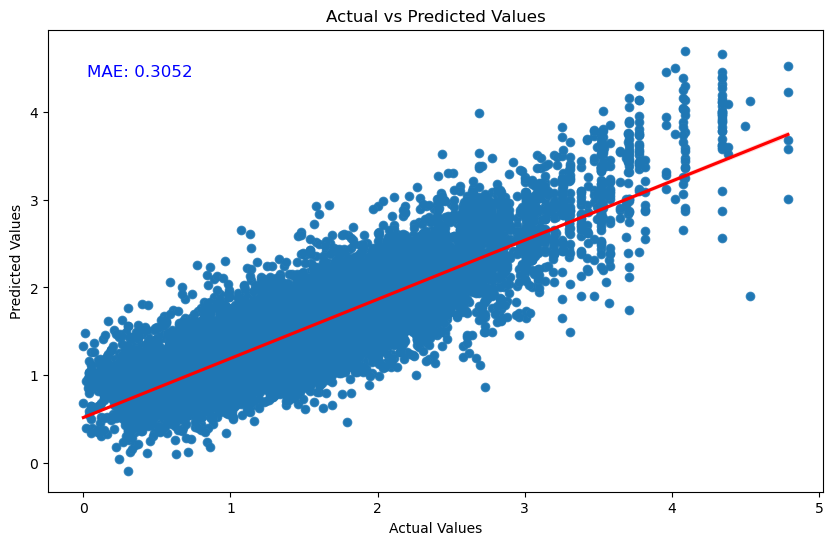

In [49]:
import seaborn as sns
# Convert y_test to a 1D array
y_test_array = y_test.values.flatten() if isinstance(y_test, pd.DataFrame) else y_test.flatten()

# Calculate performance metric (e.g., Mean Absolute Error)
mae = mean_absolute_error(y_test_array, y_pred)

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_array, y=y_pred)
sns.regplot(x=y_test_array, y=y_pred, line_kws={'color': 'red'})
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.annotate(f'MAE: {mae:.4f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='blue')
plt.show()